In [1]:
# Playing Around with Diffusion Limited Aggregation
# References:
# [1] https://youtu.be/gsJHzBTPG0Y?si=0maOxOH9jy3uw_pa&t=588
# [2] https://en.wikipedia.org/wiki/Diffusion-limited_aggregation

![DLA Example](./DLA/DLA_Example.jpg)

In [2]:
#Imports and Installs
import numpy as np
import csv
import random
import time
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
from IPython.display import display, clear_output, Image as IPImage

In [3]:
# Function to call to update availableMatrix from isBlock
def get_used_indicies(matrix):
    return [(i, j) for i in range(len(matrix)) for j in range(len(matrix[0])) if matrix[i][j] == 1]


In [4]:
# Get a random index parameter only

def get_unique_random_perimeter_index(rows, cols, used_indices):
    # Create list of all available indicies
    all_indices = [(0, j) for j in range(cols)]
    all_indices = all_indices + [(i, 0) for i in range(rows)]
    all_indices = all_indices + [(-1, j) for j in range(cols)]
    all_indices = all_indices + [(i, -1) for i in range(rows)]
    available_indices = list(set(all_indices) - set(used_indices))

    # Raise error if no index is available
    if not available_indices:
        raise ValueError("No available indices left to pick from.")
    
    #use random choice to pick a new random index
    chosen_index = random.choice(available_indices)    
    return chosen_index


In [5]:
# Get next random next index to place block and check against
# array of available indices

def get_unique_random_index(rows, cols, used_indices):
    # Create list of all available indicies
    all_indices = [(i, j) for i in range(rows) for j in range(cols)]
    available_indices = list(set(all_indices) - set(used_indices))

    # Raise error if no index is available
    if not available_indices:
        raise ValueError("No available indices left to pick from.")
    
    #use random choice to pick a new random index
    chosen_index = random.choice(available_indices)    
    return chosen_index


In [6]:
# Random Walking Direction until Hit
def move_random_adjacent(index, rows, cols, known_indices):
    i, j = index
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    attempt = 0
    walk_starts = time.time()
    new_i, new_j = i, j
    while True:
        attempt+=1
        di, dj = random.choice(directions)
        last_i, last_j = new_i, new_j
        new_i, new_j = (new_i + di) % rows, (new_j + dj) % cols
        # print('New Step:',new_i, new_j)
        if (new_i, new_j) in known_indices:
            # print('Block Found')
            walk_ends = time.time()
            time_walking = walk_ends-walk_starts
            return last_i, last_j, attempt, time_walking

In [7]:
# Get next random next index to place block and check against
# array of available indices

def get_unique_random_ceiling_index(rows, cols, used_indices):
    # Create list of all available indicies
    all_indices = [(0, i) for i in range(rows)]
    available_indices = list(set(all_indices) - set(used_indices))

    # Raise error if no index is available
    if not available_indices:
        raise ValueError("No available indices left to pick from.")
    
    #use random choice to pick a new random index
    chosen_index = random.choice(available_indices)    
    return chosen_index


In [8]:
# Random Walking Direction until Hit
# if in ceiling only walk down 
def move_random_from_ceiling(index, rows, cols, known_indices):
    i, j = index
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    directions_down = [(1, 1),  (1, -1), (1, 0)]
    ceiling = [(0, i) for i in range(rows)]
    attempt = 0
    walk_starts = time.time()
    new_i, new_j = i, j
    while True:
        attempt+=1
        if (new_i, new_j) in ceiling:
            di, dj = random.choice(directions_down)
            last_i, last_j = new_i, new_j
            new_i, new_j = (new_i + di) % rows, (new_j + dj) % cols
            # print('New Step:',new_i, new_j)
            if (new_i, new_j) in known_indices:
                # print('Block Found')
                walk_ends = time.time()
                time_walking = walk_ends-walk_starts
                return last_i, last_j, attempt, time_walking
        else: 
            di, dj = random.choice(directions)
            last_i, last_j = new_i, new_j
            new_i, new_j = (new_i + di) % rows, (new_j + dj) % cols
            # print('New Step:',new_i, new_j)
            if (new_i, new_j) in known_indices:
                # print('Block Found')
                walk_ends = time.time()
                time_walking = walk_ends-walk_starts
                return last_i, last_j, attempt, time_walking

In [9]:
def circle_indices(shape, R, W, C):
    """
    Generate indices forming a circular ring in a 2D array and set their values to 1.
    
    Parameters:
    shape (tuple): Shape of the 2D array (rows, cols)
    R (int): Radius of the ring
    W (int): Width of the ring
    C (tuple): Center of the ring (row, col)
    
    Returns:
    np.ndarray: 2D array with the circular ring marked as 1
    """
    rows, cols = shape
    cy, cx = C
    array = np.zeros(shape, dtype=int)
    
    for y in range(max(0, cy - R - W), min(rows, cy + R + W)):
        for x in range(max(0, cx - R - W), min(cols, cx + R + W)):
            dist = np.sqrt((y - cy) ** 2 + (x - cx) ** 2)
            if R <= dist <= R + W:
                array[y, x] = 1
    
    return array


#### Testing DLA with Parameter only starting points

In [ ]:
# Coordinates of Grid
grid_size = 200
x_cords = range(0,grid_size)
y_cords = range(0,grid_size)
isBlock = np.zeros((len(x_cords),len(x_cords)))

In [ ]:
#Starting Block // Seed
firstBlock_x, firstBlock_y = int(grid_size/2), int(grid_size/2)
isBlock[firstBlock_x, firstBlock_y] = True

In [28]:
# Starting Available Matrix
usedIndices = get_used_indicies(isBlock)

In [29]:
# Time for that block to walk until it hits an existing block

# How many blocks to play
totalBlock = 8000

#init
attempt_arr = []
timeWalked_arr = []

for n in range(totalBlock):
    # Get Next Random Index to Place Block
    NextBlockInd = get_unique_random_perimeter_index(len(x_cords),len(y_cords), usedIndices)

    # Move from next block start until you hit a existing block
    last_x, last_y, attempt,timeWalked = move_random_adjacent(NextBlockInd, len(x_cords),len(y_cords), usedIndices)
    attempt_arr = np.append(attempt_arr, attempt)
    timeWalked_arr = np.append(timeWalked_arr, timeWalked)

    # Given last index when last block hit update isBlock
    isBlock[last_x, last_y] = True
    
    # Update Available List
    usedIndices = get_used_indicies(isBlock)

    # Ever 10 blocks clear display and save current state of matrix
    if n % 10 == 9:
        clear_output()
        #Save isBlock, allowing for this to be done over multiple execs
        with open("./DLA/isBlock.csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows(isBlock)
        with open("./DLA/isBlock_info.csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows([attempt_arr])
            writer.writerows([timeWalked_arr])
        print('Placing Block #',n,'out of',totalBlock)
        print('Required Steps:', attempt)
        print('Time Walked:', timeWalked, '\n')
    
clear_output()
#Save isBlock, allowing for this to be done over multiple execs
with open("./DLA/PeriOnlyisBlock.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(isBlock)
with open("./DLA/PeriOnlyisBlock_info.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows([attempt_arr])
    writer.writerows([timeWalked_arr]) 
print('Program Complete')

Program Complete


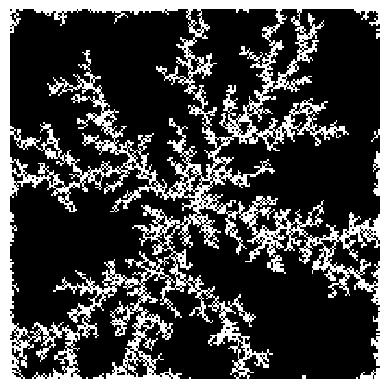

In [30]:
plt.imshow(isBlock, cmap='gray', interpolation='nearest')
plt.axis('off')
# plt.savefig('./DLA/40kPixels6kBlocks')
plt.show()


#### Loading Specific Data

In [32]:
# Read the data

with open("./DLA/PeriOnly40kPixels8kBlocks.csv", mode="r") as file:
    reader = csv.reader(file)
    data1 = [list(map(float, row)) for row in reader]

# Split into separate matrices
isBlock = data1[:]

with open("./DLA/PeriOnly40kPixels8kBlocks_info.csv", mode="r") as file:
    reader = csv.reader(file)
    data2 = [list(map(float, row)) for row in reader]
    
attempt_arr = data2[0]
timeWalked_arr = data2[1]

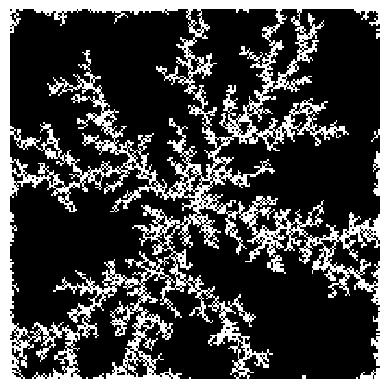

In [33]:
plt.imshow(isBlock, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.savefig('./DLA/PeriOnly40kPixels8kBlocks')
plt.show()


In [34]:
# lets looks at info

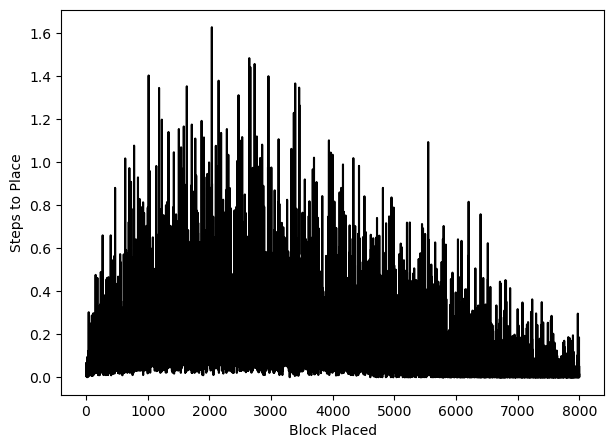

In [35]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),timeWalked_arr, color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

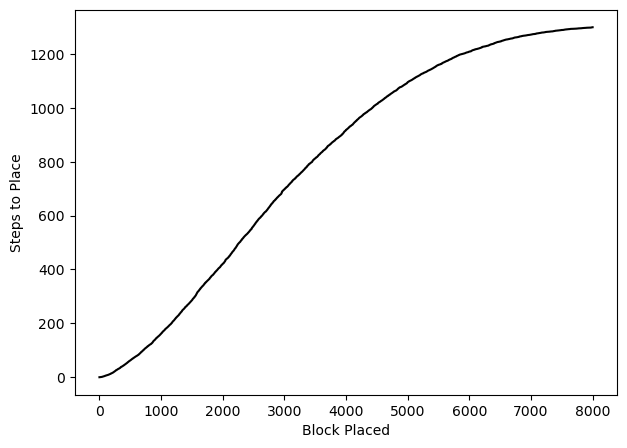

In [36]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),np.cumsum(timeWalked_arr), color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

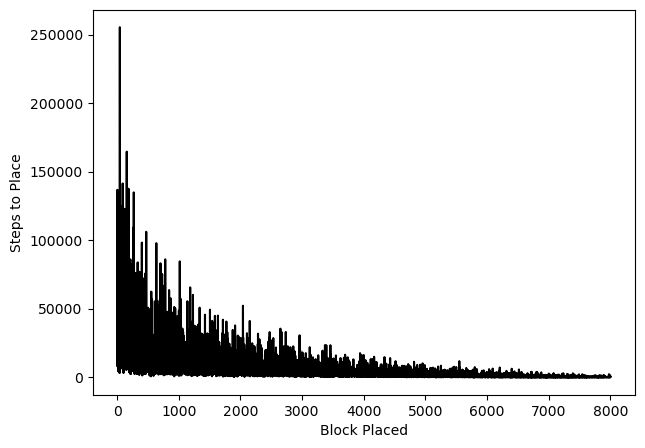

In [37]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),attempt_arr, color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

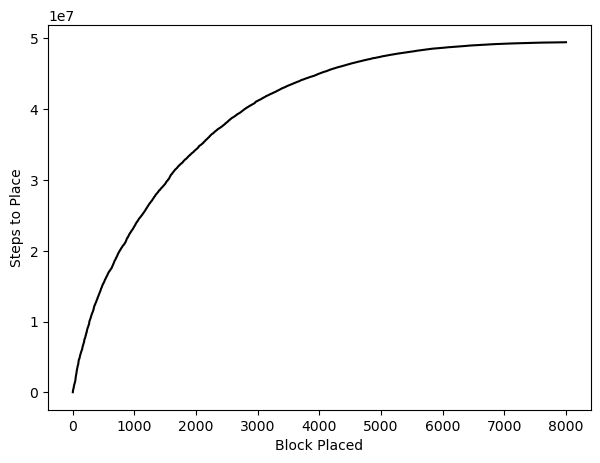

In [38]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),np.cumsum(attempt_arr), color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

### Ceiling and floor

![DLA Example](./DLA/FloorDLA_Example.jpg)

In [277]:
# Coordinates of Grid
grid_size = 200
x_cords = range(0,grid_size)
y_cords = range(0,grid_size)
isBlock = np.zeros((len(x_cords),len(y_cords)))

In [278]:
#Starting Floor
for i in range(len(x_cords)): 
         isBlock[-1, i] = True
# print(isBlock)

In [ ]:
# Starting Seed
plt.imshow(isBlock, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.show()


In [279]:
# Starting Available Matrix
usedIndices = get_used_indicies(isBlock)

In [282]:
# Time for that block to walk until it hits an existing block

# How many blocks to play
totalBlock = 4000

#init
attempt_arr = []
timeWalked_arr = []

for n in range(totalBlock):
    # Get Next Random Index to Place Block
    NextBlockInd = get_unique_random_ceiling_index(len(x_cords),len(y_cords), usedIndices)

    # Move from next block start until you hit a existing block
    last_x, last_y, attempt,timeWalked = move_random_from_ceiling(NextBlockInd, len(x_cords),len(y_cords), usedIndices)
    attempt_arr = np.append(attempt_arr, attempt)
    timeWalked_arr = np.append(timeWalked_arr, timeWalked)

    # Given last index when last block hit update isBlock
    isBlock[last_x, last_y] = True
    
    # Update Available List
    usedIndices = get_used_indicies(isBlock)

    # Ever 10 blocks clear display and save current state of matrix
    if n % 10 == 9:
        clear_output()
        #Save isBlock, allowing for this to be done over multiple execs
        with open("./DLA/isBlock.csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows(isBlock)
        with open("./DLA/isBlock_info.csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows([attempt_arr])
            writer.writerows([timeWalked_arr])
        print('Placing Block #',n,'out of',totalBlock)
        print('Required Steps:', attempt)
        print('Time Walked:', timeWalked, '\n')
    
clear_output()
#Save isBlock, allowing for this to be done over multiple execs
with open("./DLA/CeilingisBlock.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(isBlock)
with open("./DLA/CeilingisBlock_info.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows([attempt_arr])
    writer.writerows([timeWalked_arr]) 
print('Program Complete')

Program Complete


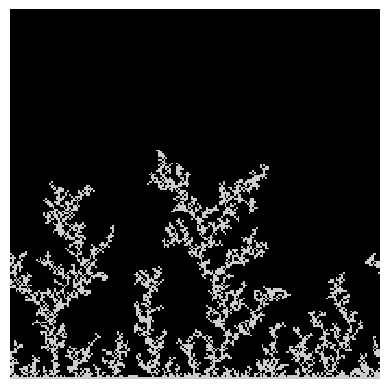

In [285]:
plt.imshow(isBlock, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.savefig('./DLA/CeilingisBlock')
plt.show()


#### 40k Pix 6500 Blocks

In [244]:
# Read the data

with open("./DLA/Ceiling40kPixels6500Blocks.csv", mode="r") as file:
    reader = csv.reader(file)
    data1 = [list(map(float, row)) for row in reader]

# Split into separate matrices
isBlock = data1[:]

with open("./DLA/Ceiling40kPixels6500Blocks_info.csv", mode="r") as file:
    reader = csv.reader(file)
    data2 = [list(map(float, row)) for row in reader]
    
attempt_arr = data2[0]
timeWalked_arr = data2[1]

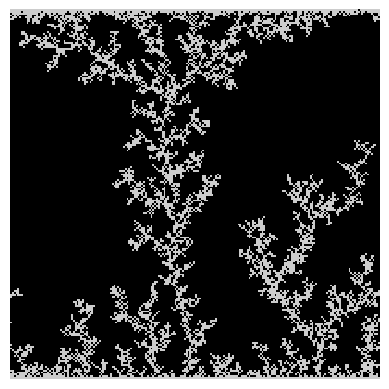

In [245]:
plt.imshow(isBlock, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.savefig('./DLA/Ceiling40kPixels6500Blocks')
plt.show()


In [246]:
# lets looks at info

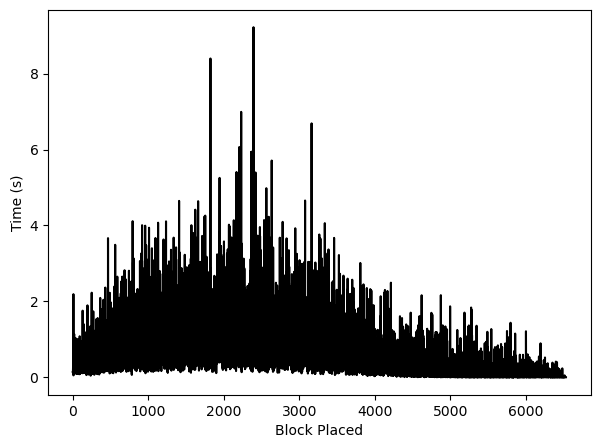

In [247]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),timeWalked_arr, color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

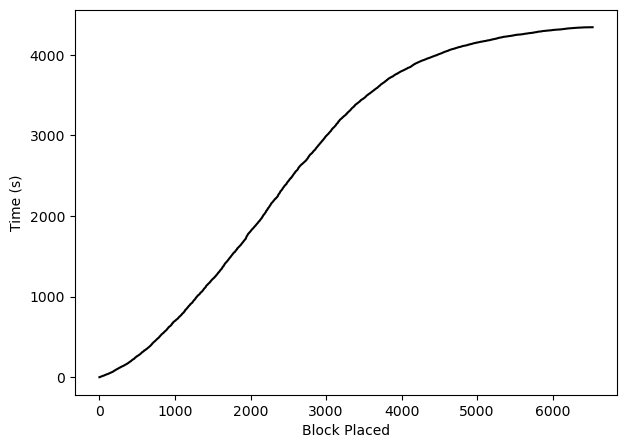

In [248]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),np.cumsum(timeWalked_arr), color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

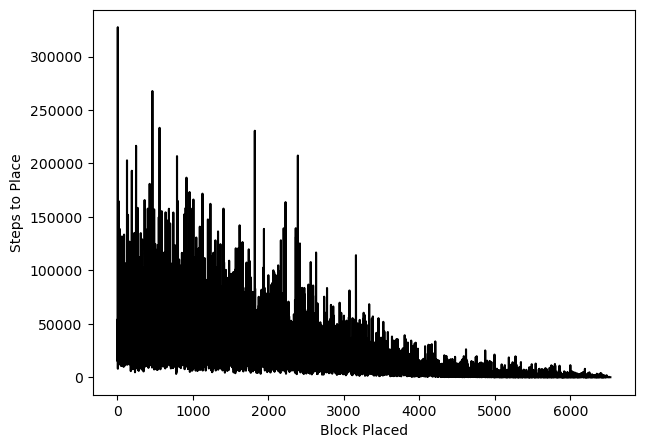

In [249]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),attempt_arr, color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

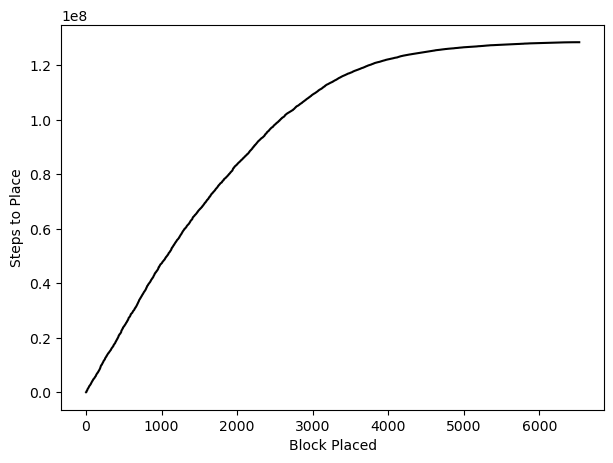

In [250]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),np.cumsum(attempt_arr), color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

#### 40k Pix 4000 Blocks

In [286]:
# Read the data

with open("./DLA/Ceiling40kPixels4kBlocks.csv", mode="r") as file:
    reader = csv.reader(file)
    data1 = [list(map(float, row)) for row in reader]

# Split into separate matrices
isBlock = data1[:]

with open("./DLA/Ceiling40kPixels4kBlocks_info.csv", mode="r") as file:
    reader = csv.reader(file)
    data2 = [list(map(float, row)) for row in reader]
    
attempt_arr = data2[0]
timeWalked_arr = data2[1]

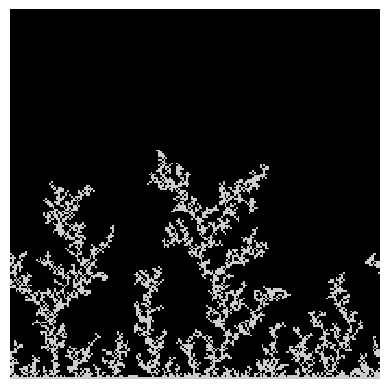

In [287]:
plt.imshow(isBlock, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.savefig('./DLA/Ceiling40kPixels4kBlocks')
plt.show()


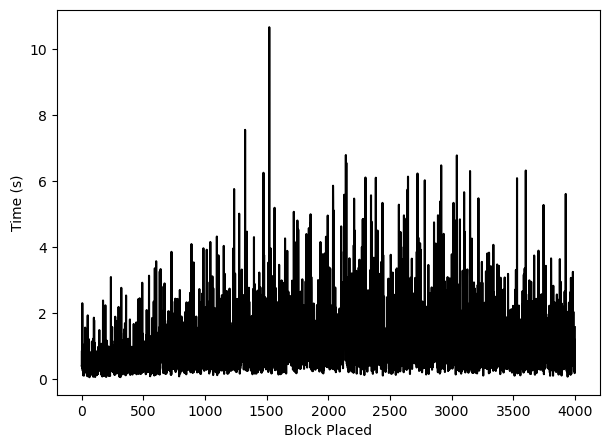

In [288]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),timeWalked_arr, color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

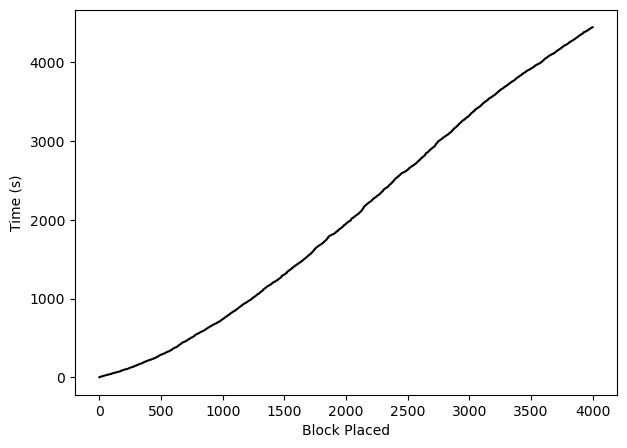

In [289]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),np.cumsum(timeWalked_arr), color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

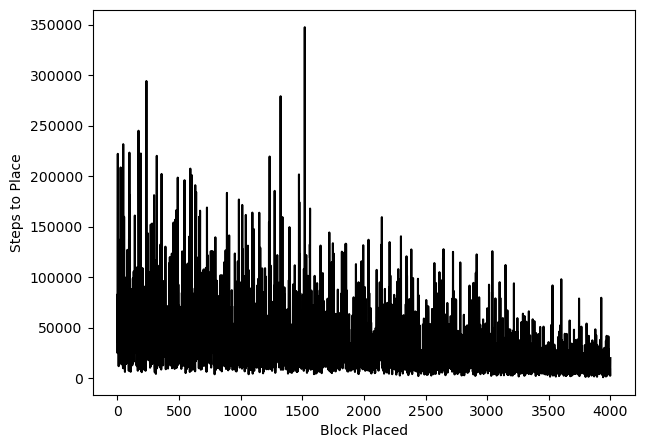

In [290]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),attempt_arr, color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

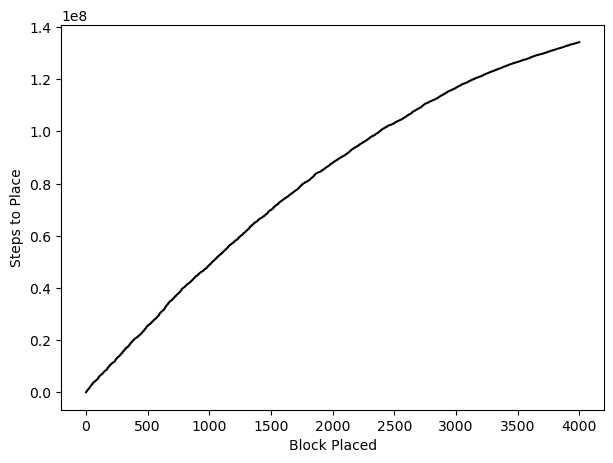

In [291]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),np.cumsum(attempt_arr), color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

### Circular Starting Seed

![DLA Circle](./DLA/CircleDLA.png)

In [10]:
# Coordinates of Grid
grid_size = 400
x_cords = range(0,grid_size)
y_cords = range(0,grid_size)
isBlock = np.zeros((len(x_cords),len(y_cords)))

In [11]:
#Starting Block // Circle Seed with Center Dot
# Add Circle
shape = (grid_size, grid_size)
Center = (200, 200) 
Radius = 150
Width = 2
isBlock = circle_indices(shape, Radius, Width, Center)

# Add Center Dot 9x9 point
firstBlock_x, firstBlock_y = int(grid_size/2), int(grid_size/2)
isBlock[firstBlock_x-3:firstBlock_x+3, firstBlock_y-3:firstBlock_y+3] = True
StartingSeed = isBlock

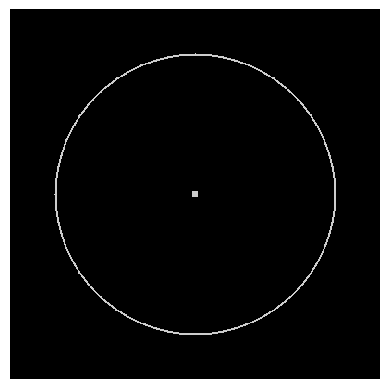

In [12]:
# Starting Seed
plt.imshow(isBlock, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.show()


In [13]:
# #Starting 
# #Save isBlock, allowing for this to be done over multiple execs
# with open("./DLA/Circle160kFrame0.csv", mode="w", newline="") as file:
#     writer = csv.writer(file)
#     writer.writerows(isBlock)
# # with open("./DLA/Circle160k.csv", mode="w", newline="") as file:
# #     writer = csv.writer(file)
# #     writer.writerows([attempt_arr])
# #     writer.writerows([timeWalked_arr]) 

In [80]:
# Read the data

with open("./DLA/Animated/Circle160kFrame54.csv", mode="r") as file:
    reader = csv.reader(file)
    data1 = [list(map(float, row)) for row in reader]

# Split into separate matrices
isBlock = np.array(data1[:])

with open("./DLA/Animated/Circle160k_info.csv", mode="r") as file:
    reader = csv.reader(file)
    data2 = [list(map(float, row)) for row in reader]
    
attempt_arr = np.array(data2[0])
timeWalked_arr = np.array(data2[1])

In [81]:
# Calculate number of blocks placed
Blocks_Placed = np.sum(isBlock) - np.sum(StartingSeed)
print(Blocks_Placed, 'number of blocks placed')
print(len(attempt_arr), 'number of blocks placed')
# or could check length of info

53000.0 number of blocks placed
54000 number of blocks placed


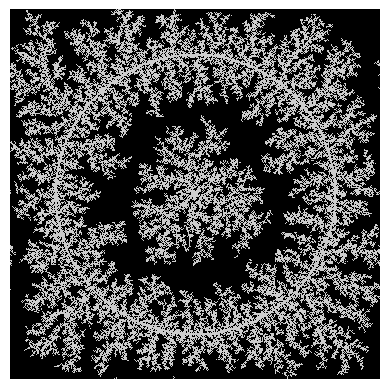

In [82]:
# Starting Seed
plt.imshow(isBlock, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.show()


In [83]:
# Starting Available Matrix
usedIndices = get_used_indicies(isBlock)

In [84]:
# #init
# attempt_arr = []
# timeWalked_arr = []

In [85]:
# Time for that block to walk until it hits an existing block
save_name = 'Circle160kFrame55'
# How many blocks to play
totalBlock = 1000


for n in range(totalBlock):
    # Get Next Random Index to Place Block
    NextBlockInd = get_unique_random_index(len(x_cords),len(y_cords), usedIndices)

    # Move from next block start until you hit a existing block
    last_x, last_y, attempt,timeWalked = move_random_adjacent(NextBlockInd, len(x_cords),len(y_cords), usedIndices)
    attempt_arr = np.append(attempt_arr, attempt)
    timeWalked_arr = np.append(timeWalked_arr, timeWalked)

    # Given last index when last block hit update isBlock
    isBlock[last_x, last_y] = True
    
    # Update Available List
    usedIndices = get_used_indicies(isBlock)

    # Ever 10 blocks clear display and save current state of matrix
    if n % 10 == 9:
        clear_output()
        #Save isBlock, allowing for this to be done over multiple execs
        with open("./DLA/Animated/"+save_name+".csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows(isBlock)
        with open("./DLA/Animated/Circle160k_info.csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows([attempt_arr])
            writer.writerows([timeWalked_arr])
        print('Placing Block #',n,'out of',totalBlock)
        print('Required Steps:', attempt)
        print('Time Walked:', timeWalked, '\n')
    
clear_output()
#Save isBlock, allowing for this to be done over multiple execs
with open("./DLA/Animated/"+save_name+".csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(isBlock)
with open("./DLA/Animated/Circle160k_info.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows([attempt_arr])
    writer.writerows([timeWalked_arr]) 
print('Program Complete')

Program Complete


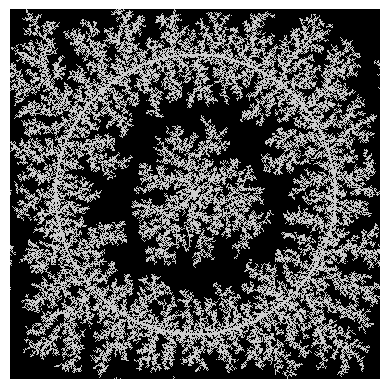

In [86]:
plt.imshow(isBlock, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
# plt.savefig("./DLA/Animated/"+save_name)
plt.show()


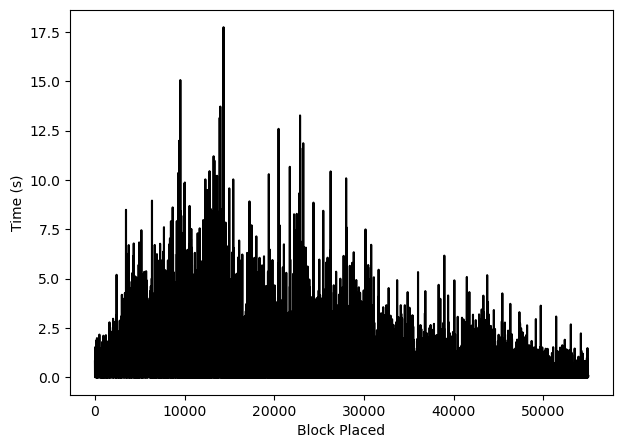

In [87]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),timeWalked_arr, color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

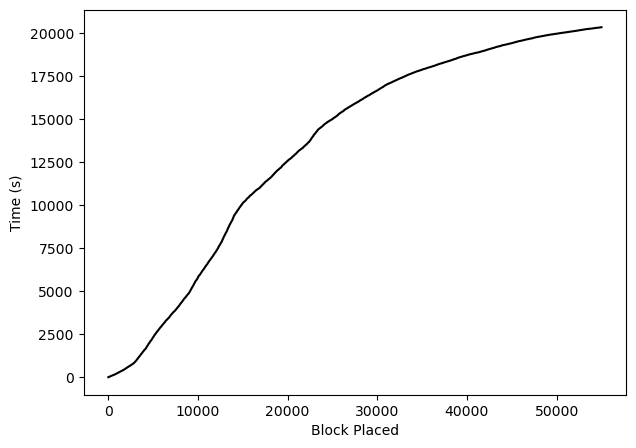

In [88]:
plt.figure(figsize=(7,5))
plt.plot(range(len(timeWalked_arr)),np.cumsum(timeWalked_arr), color = 'k')
plt.ylabel('Time (s)')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

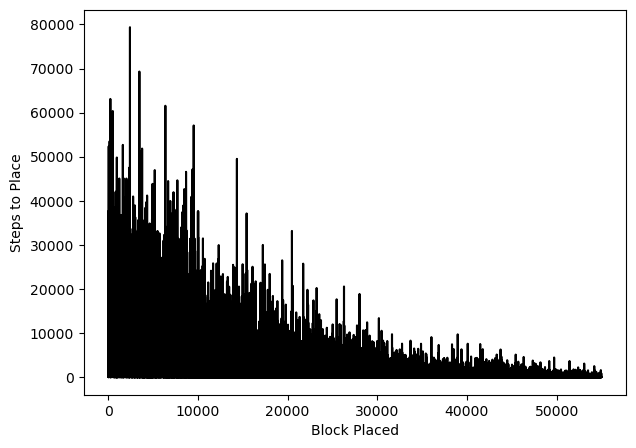

In [89]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),attempt_arr, color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

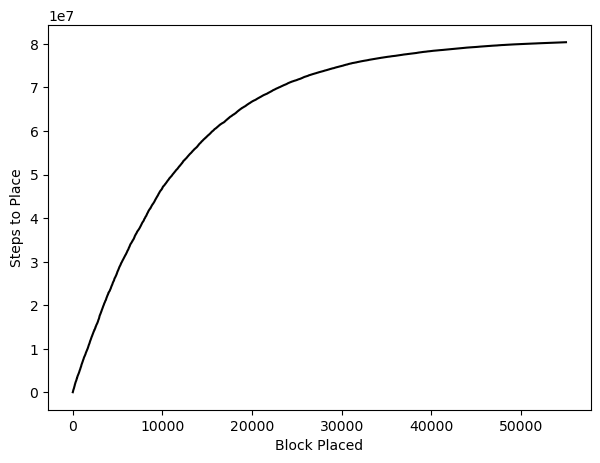

In [90]:
plt.figure(figsize=(7,5))
plt.plot(range(len(attempt_arr)),np.cumsum(attempt_arr), color = 'k')
plt.ylabel('Steps to Place')
plt.xlabel('Block Placed')
# plt.xlim(0,20)
plt.show()

#### Animating Circle

In [93]:
# For the animated circles I saved to individual files, so lets convert he 40 files in to 3d numpy array
startingFrame = 45
frames = 55
grid_size = 400
x_cords = range(0,grid_size)
y_cords = range(0,grid_size)

isBlock = np.zeros((len(x_cords),len(y_cords),frames))
tempBlock = np.load("./DLA/Animated/Circle160kAllFrames.npy")
isBlock[:,:,0:np.size(tempBlock,2)] = tempBlock


for i in range(startingFrame, frames):
    filename = './DLA/Animated/Circle160kFrame' + str(i) + '.csv'
    with open(filename, mode="r") as file:
        reader = csv.reader(file)
        isBlock[:,:,i] =  np.array([list(map(float, row)) for row in reader])
np.save("./DLA/Animated/Circle160kAllFrames", isBlock)

In [94]:
isBlock = np.load("./DLA/Animated/Circle160kAllFrames.npy")
print(np.size(isBlock,2))

55


In [102]:
# # Read frames into a numpy array
# frames = np.size(isBlock,2)
# grid_size = 400
# x_cords = range(0,grid_size)
# y_cords = range(0,grid_size)
# isBlock = np.zeros((len(x_cords),len(y_cords),frames))

# ReadingFromFiles = False
# ReadingFromNpy = True

# if ReadingFromFiles == True:
#     for i in range(frames):
#         filename = './DLA/Animated/Circle160kFrame' + str(i) + '.csv'
#         with open(filename, mode="r") as file:
#             reader = csv.reader(file)
#             isBlock[:,:,i] =  np.array([list(map(float, row)) for row in reader])
# if ReadingFromNpy == True:
#     isBlock = np.load("./DLA/Animated/Circle160kAllFrames.npy")
#     lastframe = isBlock[:,:,-1]
#     for i in range(np.size(isBlock,2),frames):
#         filename = './DLA/Animated/Circle160kFrame' + str(i) + '.csv'
#         with open(filename, mode="r") as file:
#             reader = csv.reader(file)
#             isBlock[:,:,i] =  np.array([list(map(float, row)) for row in reader])
            

In [97]:
# Define the scaling factor (e.g., 4x larger)
scale_factor = 2
new_size = (isBlock.shape[0] * scale_factor, isBlock.shape[1] * scale_factor)

frames = []

# Convert each 2D slice into an image
for i in range(np.size(isBlock,2)):
    img = Image.fromarray((isBlock[:,:,i] * 255).astype(np.uint8))
     # Resize the image
    img = img.resize(new_size, Image.NEAREST)  # Use NEAREST to keep pixelated look
    frames.append(img)

# Save as a GIF
isSaving = True
if isSaving == True: 
    gif_path = "./DLA/Animated/Circle55k.gif"
    frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=200, loop=5)

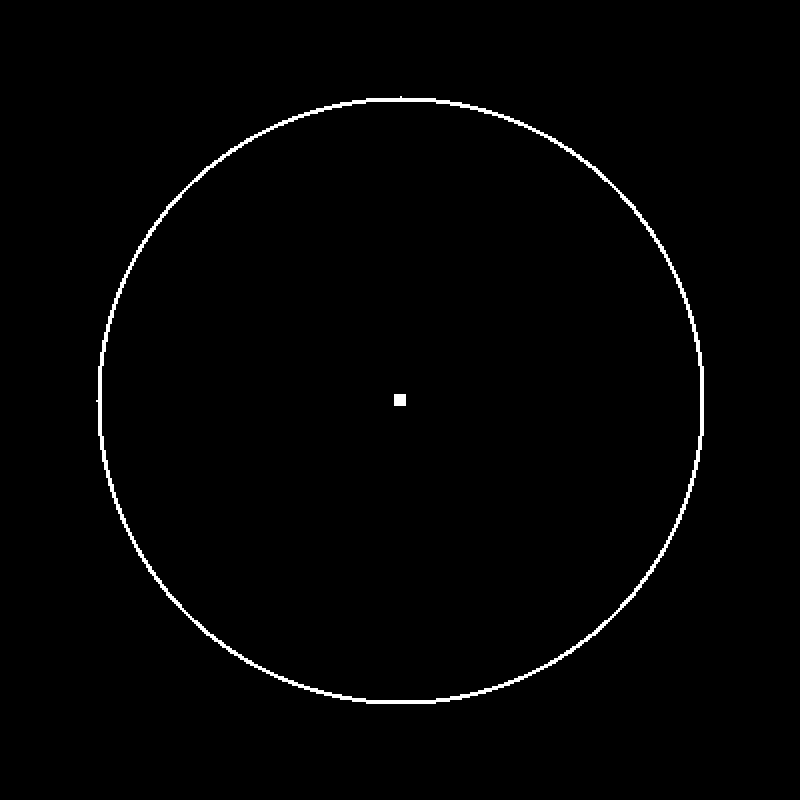

In [98]:
display(IPImage(gif_path))

In [35]:
#### Perimeter

In [ ]:
# How many blocks to play
BlocksPerFrame = 1000
StartingFrame = 0
TotalBlocks = 20000
Frames = int(TotalBlocks/BlocksPerFrame)tempBlock

In [ ]:
# Coordinates of Grid
grid_size = 500
x_cords = range(0,grid_size)
y_cords = range(0,grid_size)
isBlock = np.zeros((len(x_cords),len(x_cords),Frames))
StartingisBlock = isBlock

In [ ]:
#Starting Block // Seed
isFirst = True
isLoading = False

if isFirst == True: 
    firstBlock_x, firstBlock_y = int(grid_size/2), int(grid_size/2)
    isBlock[firstBlock_y-1:firstBlock_y+1, firstBlock_x-1:firstBlock_x+1,0] = True
    plt.imshow(isBlock[:,:,-1], cmap='nipy_spectral', interpolation='nearest')
    plt.axis('off')
    plt.show()
    #init
    attempt_arr = []
    timeWalked_arr = []    
    # Starting Available Matrix
    usedIndices = get_used_indicies(isBlock[:,:,0])
    
if isLoading == True:
    tempBlock = np.load("./DLA/Animated/Peri250kAllFrames.npy")
    isBlock[:,:,0:np.size(tempBlock,2)] = tempBlock
    # Starting Seed
    plt.imshow(isBlock[:,:,-1], cmap='nipy_spectral', interpolation='nearest')
    plt.axis('off')
    plt.show()
    with open("./DLA/Animated/Peri250k_info.csv", mode="r") as file:
    reader = csv.reader(file)
    data = [list(map(float, row)) for row in reader]
    attempt_arr = np.array(data[0])
    timeWalked_arr = np.array(data[1])
    # Starting Available Matrix
    usedIndices = get_used_indicies(isBlock[:,:,-1])

In [ ]:
# Calculate number of blocks placed
firstBlock_x, firstBlock_y = int(grid_size/2), int(grid_size/2)
StartingSeed[firstBlock_y-1:firstBlock_y+1, firstBlock_x-1:firstBlock_x+1,0] = True
Blocks_Placed = np.sum(isBlock) - np.sum(StartingSeed)
print(Blocks_Placed, 'number of blocks placed')

In [ ]:

for f in range(StartingFrame, Frames):
    for n in range(f*BlocksPerFrame+StartFrame*BlocksPerFrame,f*BlocksPerFrame+StartFrame*BlocksPerFrame+BlocksPerFrame):
        # Get Next Random Index to Place Block
        NextBlockInd = get_unique_random_perimeter_index(len(x_cords),len(y_cords), usedIndices)

        # Move from next block start until you hit a existing block
        last_x, last_y, attempt,timeWalked = move_random_adjacent(NextBlockInd, len(x_cords),len(y_cords), usedIndices)
        attempt_arr = np.append(attempt_arr, attempt)
        timeWalked_arr = np.append(timeWalked_arr, timeWalked)

        # Given last index when last block hit update isBlock
        isBlock[last_x, last_y,f] = True

        # Update Available List
        usedIndices = get_used_indicies(isBlock[:,:,-1])

        # Save 10 times per frame 
        if n % int(BlocksPerFrame/10)  == 9:
            clear_output()
            #Save isBlock, allowing for this to be done over multiple execs
            np.save("./DLA/Animated/Peri250kAllFrames", isBlock)
            with open("./DLA/Peri250k_info.csv", mode="w", newline="") as file:
                writer = csv.writer(file)
                writer.writerows([attempt_arr])
                writer.writerows([timeWalked_arr])
            print('Frame: ',f)
            print('Placing Block #',n,'out of',totalBlock)
            print('Required Steps:', attempt)
            print('Time Walked:', timeWalked, '\n')
    
clear_output()
#Save isBlock, allowing for this to be done over multiple execs
np.save("./DLA/Animated/Peri250kAllFrames", isBlock)
with open("./DLA/Peri250k_info.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows([attempt_arr])
    writer.writerows([timeWalked_arr])
print('Placing Block #',n,'out of',totalBlock)
print('Required Steps:', attempt)
print('Time Walked:', timeWalked, '\n')
print('Program Complete')

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'